In [1]:
%matplotlib inline

import keras
import losswise
import os
import time

import pandas

import pickle

from PIL import Image as pil_image

import matplotlib.pyplot as plt

losswise.set_api_key("OTOH203ED")

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Conv2DTranspose, ConvLSTM2D, TimeDistributed
from keras.models import Model, Sequential
from keras.losses import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from losswise.libs import LosswiseKerasCallback
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

import tensorflow as tf

import numpy as np

import keras.backend as K

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from moviepy.editor import VideoFileClip

import random
import logging

Using TensorFlow backend.


In [2]:
# Important settings
data_dir = "recurrent"
trainFile = "train.pickle"
testFile = "test.pickle"

In [3]:
# Data augmentation settings NOT IN USE RIGHT NOW
width_shift = 0
height_shift = 0
zoom_range = 0
rotation_range = 0

In [4]:
# Hyperparameters
batch_size = 8
#rescale = False
input_size = (168, 396)
color_mode = "grayscale"
filters= 16
timesteps = 15

epochs = 20

trackedFeatures = {}

In [5]:
import matplotlib.image as mpimg
import random
import hashlib

def getImg(image):
    img = pil_image.open(image)
    x = np.asarray(img, dtype=K.floatx())[:,:,0]/255.
    x = x.reshape((x.shape[0], x.shape[1], 1))
    return 1.-x

def genGaussian(input_size, coords, sigma=5):
    x = coords[0]
    y = coords[1]
    [XX, YY] = np.meshgrid(np.arange(0,input_size[1]), np.arange(0,input_size[0]))
    return np.exp(-(np.square(YY-y) + np.square(XX-x))/(2*sigma**2)).reshape(*input_size, 1)

# Fix code for this from https://github.com/talmo/leap/blob/master/leap/pts2confmaps.m
class RecurrentPawGenerator(keras.utils.Sequence):
    
    global trackedFeatures
    
    tracked = ['paw1LH_top', 'paw2LF_top', 'paw3RF_top', 'paw4RH_top', 'tailBase_top', 'tailMid_top']
    cols = list(range(19))
    
    framenumName = 'Unnamed: 0'
    
    def __init__(self, baseDir, input_size, batch_size, dataFile, windowSize):
        global trackedFeatures
        self.baseDir = baseDir
        self.batch_size = batch_size
        self.image_shape = input_size+(1,)
        self.input_size = input_size
        self.dataFile = dataFile
        self.windowSize = windowSize
        with open(dataFile, 'rb') as f:
            self.training_examples = pickle.load(f)
        self.clips = {}
        neededFrames = {}
        for frame in self.training_examples:
            if frame['session'] not in neededFrames:
                neededFrames[frame['session']] = set()
            neededFrames[frame['session']].update(list(range(frame['frameNum']-self.windowSize+1, frame['frameNum']+1)))
        for session in neededFrames:
            tmp = pandas.read_csv(os.path.join(self.baseDir, session, 'trackedFeaturesRaw.csv'), usecols=self.cols)
            tmp = tmp.to_dict('records')
            tmp = {int(sample[self.framenumName]): {feature: (sample[feature], sample[feature+'.1']) for feature in self.tracked} for sample in tmp}
            if session not in trackedFeatures:
                trackedFeatures[session] = {i: tmp[i] for i in neededFrames[session]}
            else:
                trackedFeatures[session].update({i: tmp[i] for i in neededFrames[session]})
            print('Loaded', session)
        random.shuffle(self.training_examples)
        
    def __len__(self):
        return int(np.ceil(len(self.training_examples)/self.batch_size))
    
    def getImg(self, frame):
        global trackedFeatures
        if frame['session'] not in self.clips:
            self.clips[frame['session']] = VideoFileClip(os.path.join(self.baseDir, frame['session'], 'runTop.mp4'))
            print('Loaded video', frame['session'])
        toRet = []
        for i in range(frame['frameNum']-self.windowSize+1, frame['frameNum']+1):
            img = self.clips[frame['session']].get_frame(i/self.clips[frame['session']].fps)
            x = np.asarray(img, dtype=K.floatx())[:,:,0]/255.
            x = x.reshape((x.shape[0], x.shape[1], 1))
            toRet.append(x)
        return toRet
    
    def __getitem__(self, idx):
        global trackedFeatures
        if idx>=int(np.ceil(len(self.training_examples)/self.batch_size)):
            print("nopeeee")
            return -1
                                            
        self.x = [self.getImg(frame) for frame in self.training_examples[idx*self.batch_size:min((idx+1)*self.batch_size, len(self.training_examples))]]
        self.x = np.asarray(self.x)
        self.mean = np.reshape([0.257], [1,1,1,1])
        self.std = np.reshape([0.288], [1,1,1,1])
        self.x-=self.mean
        self.x/=self.std
        self.y = np.asarray([[np.concatenate([genGaussian(self.input_size, trackedFeatures[frame['session']][j][i]) for i in self.tracked], axis=2) for j in range(frame['frameNum']-self.windowSize+1, frame['frameNum']+1)] for frame in self.training_examples[idx*self.batch_size:min((idx+1)*self.batch_size, len(self.training_examples))]])
        
        return self.x, self.y

In [6]:
test_gen = RecurrentPawGenerator(os.path.join(data_dir, 'sessions'), input_size, batch_size, os.path.join(data_dir, testFile), timesteps)
train_gen = RecurrentPawGenerator(os.path.join(data_dir, 'sessions'), input_size, batch_size, os.path.join(data_dir, trainFile), timesteps)

Loaded 180623_000
Loaded 180623_006
Loaded 180619_009
Loaded 180613_000
Loaded 180623_002
Loaded 180623_001
Loaded 180623_005
Loaded 180623_003
Loaded 180605_000
Loaded 180613_001
Loaded 180607_004
Loaded 180618_010
Loaded 180605_002
Loaded 180605_001
Loaded 180623_004
Loaded 180613_002
Loaded 180623_000
Loaded 180623_006
Loaded 180619_009
Loaded 180613_000
Loaded 180623_002
Loaded 180623_001
Loaded 180623_005
Loaded 180623_003
Loaded 180605_000
Loaded 180613_001
Loaded 180607_004
Loaded 180618_010
Loaded 180605_002
Loaded 180605_001
Loaded 180623_004
Loaded 180613_002


In [7]:
start = time.time()
for i in range(2):
    x, y = train_gen[i]
    x, y = test_gen[i]
print(time.time()-start)

Loaded video 180607_004
Loaded video 180613_000
Loaded video 180623_003
Loaded video 180605_001
Loaded video 180623_002
Loaded video 180623_004
Loaded video 180613_000
Loaded video 180623_006
Loaded video 180623_002
Loaded video 180605_001
Loaded video 180623_003
Loaded video 180623_001
Loaded video 180619_009
Loaded video 180618_010
Loaded video 180623_006
Loaded video 180613_001
Loaded video 180607_004
Loaded video 180623_000
Loaded video 180618_010
9.27592921257019


In [8]:
del x
del y

In [13]:
x.shape

(32, 15, 168, 396, 1)

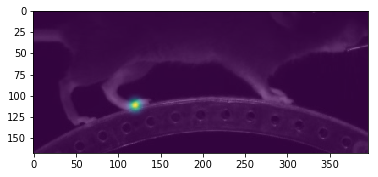

In [35]:
i=0

plt.imshow(np.concatenate((x[i][1], x[i][1], x[i][1]), axis=2)*0.288+0.257)
plt.imshow(y[i,1,:,:,0], alpha=0.7, cmap='viridis')
plt.show()

In [7]:
x_in = Input(input_size+(1,))

x1 = Conv2D(filters, kernel_size=3, padding="same", activation="relu")(x_in)
x1 = Conv2D(filters, kernel_size=3, padding="same", activation="relu")(x1)
x1 = Conv2D(filters, kernel_size=3, padding="same", activation="relu")(x1)
x1_pool = MaxPooling2D(pool_size=2, strides=2, padding="same")(x1)

x2 = Conv2D(filters*2, kernel_size=3, padding="same", activation="relu")(x1_pool)
x2 = Conv2D(filters*2, kernel_size=3, padding="same", activation="relu")(x2)
x2 = Conv2D(filters*2, kernel_size=3, padding="same", activation="relu")(x2)
x2_pool = MaxPooling2D(pool_size=2, strides=2, padding="same")(x2)

top = Model(inputs=x_in, outputs=x2_pool, name="top")

time_in = Input((timesteps,)+input_size+(1,))
time1 = TimeDistributed(top)(time_in)

full = ConvLSTM2D(filters*2, kernel_size=3, padding='same', return_sequences=True)(time1)

x_in2 = Input(input_size+(filters*2,))

x3 = Conv2D(filters*4, kernel_size=3, padding="same", activation="relu")(x_in2)
x3 = Conv2D(filters*4, kernel_size=3, padding="same", activation="relu")(x3)
x3 = Conv2D(filters*4, kernel_size=3, padding="same", activation="relu")(x3)

x4 = Conv2DTranspose(filters*2, kernel_size=3, strides=2, padding="same", activation="relu", kernel_initializer="glorot_normal")(x3)
x4 = Conv2D(filters*2, kernel_size=3, padding="same", activation="relu")(x4)
x4 = Conv2D(filters*2, kernel_size=3, padding="same", activation="relu")(x4)

x_out = Conv2DTranspose(6, kernel_size=3, strides=2, padding="same", activation="linear", kernel_initializer="glorot_normal")(x4)

bottom = Model(inputs=x_in2, output=x_out, name="bottom")
time2 = TimeDistributed(bottom)(full)

def meanDistance(y_true, y_pred):
    in_shape = tf.shape(y_true)

    # Flatten height/width dims
    flat_true = tf.reshape(y_true, [in_shape[0], -1, in_shape[-1]])
    flat_pred = tf.reshape(y_pred, [in_shape[0], -1, in_shape[-1]])

    # Find peaks in linear indices
    idx_true = tf.argmax(flat_true, axis=1)
    idx_pred = tf.argmax(flat_pred, axis=1)

    # Convert linear indices to subscripts
    rows_true = tf.floor_div(tf.cast(idx_true,tf.int32), in_shape[2])
    cols_true = tf.floormod(tf.cast(idx_true,tf.int32), in_shape[2])
    
    rows_pred = tf.floor_div(tf.cast(idx_pred, tf.int32), in_shape[2])
    cols_pred = tf.floormod(tf.cast(idx_pred, tf.int32), in_shape[2])
    
    row_diff = tf.square(tf.subtract(tf.cast(rows_true, tf.float32), tf.cast(rows_pred, tf.float32)))
    col_diff = tf.square(tf.subtract(tf.cast(cols_true, tf.float32), tf.cast(cols_pred, tf.float32)))
    distances = tf.sqrt(tf.add(row_diff, col_diff))
    
    return tf.reduce_mean(distances)

# Compile
net = Model(inputs=time_in, outputs=time2, name="RecurrentLeap")
net.compile(optimizer=Adam(amsgrad=False), loss="mean_squared_error", metrics=[meanDistance])

net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 15, 168, 396, 1)   0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 42, 99, 32)    27936     
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 15, 42, 99, 32)    73856     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 168, 396, 6)   131046    
Total params: 232,838
Trainable params: 232,838
Non-trainable params: 0
_________________________________________________________________


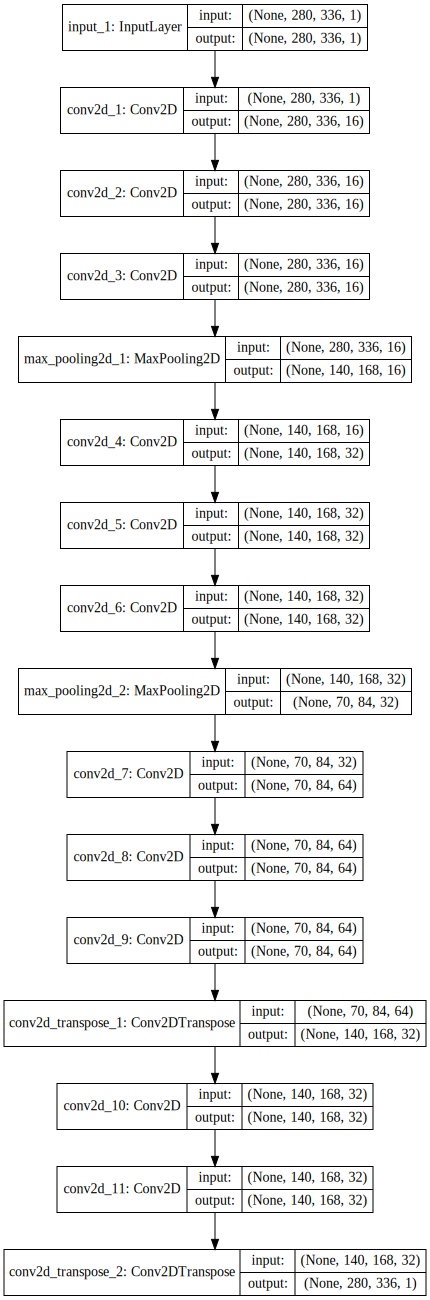

In [8]:
SVG(model_to_dot(net, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
modelName = "initialrecurrent16"

net.fit_generator(
    train_gen,
    verbose=1,
    epochs=epochs,
    validation_data=test_gen,
    workers=2,
    use_multiprocessing=True,
    callbacks=[LosswiseKerasCallback(tag=modelName, display_interval=1), ModelCheckpoint("models/"+modelName+".{epoch:02d}-{val_loss:.2f}.h5", period=5, verbose=1)])

Epoch 1/20
Loaded video 180623_004
Loaded video 180623_004
Loaded video 180607_004
Loaded video 180605_002
Loaded video 180623_006
Loaded video 180623_000
Loaded video 180605_001
Loaded video 180623_006
Loaded video 180623_003
Loaded video 180613_000
Loaded video 180613_002
Loaded video 180623_002
Loaded video 180607_004
Loaded video 180623_003
Loaded video 180623_001
Loaded video 180623_001
Loaded video 180605_002
Loaded video 180613_000
Loaded video 180605_000
Loaded video 180613_001
Loaded video 180623_005
Loaded video 180618_010
Loaded video 180623_005
Loaded video 180623_000
Loaded video 180619_009
  3/400 [..............................] - ETA: 26:29 - loss: 0.0012 - meanDistance: 2358.2464Loaded video 180613_002
Loaded video 180605_001
Loaded video 180613_001
Loaded video 180623_002
Loaded video 180618_010
399/400 [============================>.] - ETA: 1s - loss: 0.0010 - meanDistance: 2115.2844Loaded video 180619_009
Loaded video 180618_010
Loaded video 180605_000
Loaded video

In [14]:
val_loss, val_meanDist = net.evaluate_generator(test_gen)
print("Validation loss:", val_loss)
print("Validation mean distance:", val_meanDist)

Validation loss: 0.000342489128505
Validation mean distance: 4.08452698956


In [29]:
def getCoords(y_pred):
    in_shape = np.shape(y_pred)

    # Flatten height/width dims
    flat_pred = np.reshape(y_pred, [in_shape[0], -1, in_shape[-1]])

    # Find peaks in linear indices
    idx_pred = np.argmax(flat_pred, axis=1)

    # Convert linear indices to subscripts
    rows_pred = np.squeeze(np.floor_divide(idx_pred.astype(np.int32), in_shape[2]), axis=-1)
    cols_pred = np.squeeze(np.mod(idx_pred.astype(np.int32), in_shape[2]), axis=-1)
    
    return list(zip(cols_pred, rows_pred))

In [32]:
getCoords(net.predict(test_gen[0][0]))

[(203, 155),
 (269, 135),
 (176, 149),
 (247, 179),
 (101, 191),
 (17, 178),
 (101, 159),
 (72, 176),
 (157, 195),
 (223, 167),
 (165, 203),
 (64, 156),
 (335, 208),
 (36, 164),
 (269, 207),
 (276, 148),
 (335, 176),
 (320, 156),
 (135, 155),
 (177, 183),
 (249, 183),
 (335, 148),
 (216, 197),
 (237, 151),
 (144, 156),
 (119, 183),
 (100, 156),
 (32, 216),
 (40, 181),
 (331, 155),
 (264, 204),
 (36, 184)]

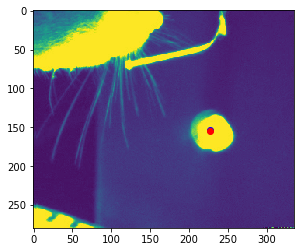

In [159]:
j+=1

i = j%32
batch = int(j/32)

plt.imshow(np.squeeze(test_gen[batch][0][i]))
plt.plot(*getCoords(net.predict(np.expand_dims(test_gen[batch][0][i], axis=0)))[0], 'bo')
plt.plot(*getCoords(np.expand_dims(test_gen[batch][1][i], axis=0))[0], 'ro')